In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [13]:
from google.colab import files
def subplot_drawing(revenue_list, total_surplus_list, surplus_list, price_list, access_list, _filename = 'figure'):
    N = 4
    fig, axs = plt.subplots(1, N)
    fig.set_figheight(4)
    fig.set_figwidth(24)

    n_iter = len(revenue_list)
    iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]
    axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
    axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0, linestyle='--')
    axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0, linestyle=':')
    axs[0].set_xlim([0, 1])
    axs[0].grid()

    level = 1
    axs[1].plot(iter_list, [p[0] for p in price_list], label=r'$p_1$',linewidth=3.0, alpha=level)
    axs[1].plot(iter_list, [p[1] for p in price_list], label=r'$p_2$',linewidth=3.0, alpha=level, linestyle='--')
    axs[1].set_xlim([0, 1])
    axs[1].grid()

    axs[2].plot(iter_list, [a[0] for a in access_list], label=r'$A_1$',linewidth=3.0, alpha=level)
    axs[2].plot(iter_list, [a[1] for a in access_list], label=r'$A_2$',linewidth=3.0, alpha=level, linestyle='--')
    axs[2].set_xlim([0, 1])
    axs[2].grid()

    axs[3].plot(iter_list, [s[0] for s in surplus_list], label=r'$\mathcal{S}_1$',linewidth=3.0)
    axs[3].plot(iter_list, [s[1] for s in surplus_list], label=r'$\mathcal{S}_2$',linewidth=3.0, linestyle='--')
    axs[3].set_xlim([0, 1])
    axs[3].grid()

    for i in range(N):
        axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=3, prop={"size":16})

    for ax in axs.flat:
        ax.set(xlabel=r'$\alpha$')
        ax.xaxis.label.set_fontsize(18) #28

    plt.savefig(_filename + '.pdf', format='pdf', bbox_inches='tight')
    files.download(_filename + '.pdf')
    plt.show()

In [7]:
def func(l1, l2, Lambda, b, t, K, form='l'):
    t1, t2 = t[0], t[1]

    if form == 'l':
        p1, p2 = b[0] * (1 - l1 / Lambda[0]), b[1] * (1 - l2 / Lambda[1])
    elif form == 'e':
        eps = 1e-3
        p1, p2 = -1 / b[0] * np.log((l1 + eps) / Lambda[0]), -1 / b[1] * np.log((l2 + eps) / Lambda[1])

    if l1 == 0:
        pi_10 = 1
        pi_01 = 0
        R = 0
    elif l2 == 0:
        pi_01 = 1
        pi_10 = 0
        R = 0
    else:
        Z_k, pi_10, pi_01 = 0, 0, 0
        for x1 in range(K + 1):
            for x2 in range(K + 1 - x1):
                for y1 in range(K + 1 - x1 - x2):
                    y2 = K - x1 - x2 - y1
                    Z = (pow(1 / l1, x1) * pow(1 / l2, x2) *
                         pow(t1, y1) / math.factorial(y1) *
                         pow(t2, y2) / math.factorial(y2))

                    if x1 >= 1:
                        pi_10 += Z
                    if x2 >= 1:
                        pi_01 += Z
                    Z_k += Z

        pi_10 = pi_10 / Z_k
        pi_01 = pi_01 / Z_k
        R = l1 * pi_10 * p1 + l2 * pi_01 * p2

    if form == 'l':
        A1 = (1 - p1 / b[0]) * pi_10
        A2 = (1 - p2 / b[1]) * pi_01
        S1 = pow(b[0] - p1, 2) / (2 * b[0]) * pi_10
        S2 = pow(b[1] - p2, 2) / (2 * b[1]) * pi_01
    elif form == 'e':
        A1 = l1 / Lambda[0] * pi_10
        A2 = l2 / Lambda[1] * pi_01
        S1 = 1 / b[0] * l1 / Lambda[0] * pi_10
        S2 = 1 / b[1] * l2 / Lambda[1] * pi_01

    tS = Lambda[0] * S1 + Lambda[1] * S2

    return {
        'l': [l1, l2],
        'p': [p1, p2],
        'pi': [pi_10, pi_01],
        'A': [A1, A2],
        'S': [S1, S2],
        'tS': tS,
        'R': R
    }

In [8]:
def Fair_algorithm(Lambda, b, t, K, d=[1, 1], fairness='Vanilla', alpha=0, M=0, step=0.1, form='l', debug=False):

    if fairness not in ('Access', 'Vanilla', 'Price'):
        raise ValueError("Invalid input! The 'input' should be either 'Price' or 'Access'.")

    opt_dict = {}
    opt_rev = 0
    opt_p1, opt_p2 = 0, 0
    ts, s, a = 0, [], []

    num0 = int(Lambda[0] / step) + 1
    num1 = int(Lambda[1] / step) + 1

    if alpha != 1:
        for l1 in np.linspace(0, Lambda[0], num0):
            for l2 in np.linspace(0, Lambda[1], num1):
                result = func(l1, l2, Lambda, b, t, K, form=form)
                A1, A2 = result['A']
                p1, p2 = result['p']

                if fairness == 'Access' and alpha != 0:
                    if np.abs(A1 - A2) > (1 - alpha) * M:
                        continue
                elif fairness == 'Price' and alpha != 0:
                    if np.abs(p1 - p2) > (1 - alpha) * M:
                        continue

                if result['R'] > opt_rev:
                    opt_rev = result['R']
                    opt_dict = result
                    opt_p1, opt_p2 = result['p'][0], result['p'][1]
    else:
      if fairness == 'Access':
        if Lambda[0] == Lambda[1]:
            for l1 in np.linspace(0, Lambda[0], num0):
                for l2 in np.linspace(0, Lambda[1], num1):
                    result = func(l1, l2, Lambda, b, t, K, form=form)
                    if result['R'] > opt_rev:
                        opt_rev = result['R']
                        opt_dict = result
                        opt_p1, opt_p2 = result['p'][0], result['p'][1]
        else:
            opt_rev = 0
            opt_dict = {'tS': 0, 'S': [0, 0], 'A': [0, 0]}
            if form == 'l':
                opt_p1, opt_p2 = b[0], b[1]
            else:
                eps = 1e-5
                opt_p1, opt_p2 = -1 / b[0] * np.log(eps / Lambda[0]), -1 / b[1] * np.log(eps / Lambda[1])
      else:
        for l1 in np.linspace(0, Lambda[0], num0):
          p1 = b[0] * (1-l1/Lambda[0])
          l2 = Lambda[1] * (1-p1/b[1])
          result = func(l1, l2, Lambda, b, t, K, form=form)
          if result['R'] > opt_rev:
            opt_rev = result['R']
            opt_dict = result
            opt_p1, opt_p2 = result['p'][0], result['p'][1]

    if fairness == 'Vanilla':
        return {'Price': np.abs(opt_p1 - opt_p2), 'Access': np.abs(opt_dict['A'][0] - opt_dict['A'][1])}
    else:
        return opt_rev, opt_dict['tS'], opt_dict['S'], [opt_p1, opt_p2], opt_dict['A']


In [9]:
def simulator(Lambda, b, t, K, step=0.01, fairness='Access', form='l', debug=False):

    M_star = Fair_algorithm(Lambda, b, t, K, fairness='Vanilla', form=form)
    print(M_star)

    rev_list, ts_list, s_list, p_list, a_list = [], [], [], [], []

    for a in range(11):
        print(f'alpha: {a / 10}')

        rev, ts, s, price, access = Fair_algorithm(
            Lambda, b, t, K, step=step, fairness=fairness,
            alpha=a / 10, M=M_star[fairness], form=form
        )

        rev_list.append(rev)
        ts_list.append(ts)
        s_list.append(s)
        p_list.append(price)
        a_list.append(access)

    return rev_list, ts_list, s_list, p_list, a_list

# Experiments

In [16]:
Lambda = [1, 4]
b = [1, 1]
t = [2, 2]
K = 5

rev_list, ts_list, s_list, p_list, a_list = simulator(Lambda, b, t, K, step=0.001, fairness='Access')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

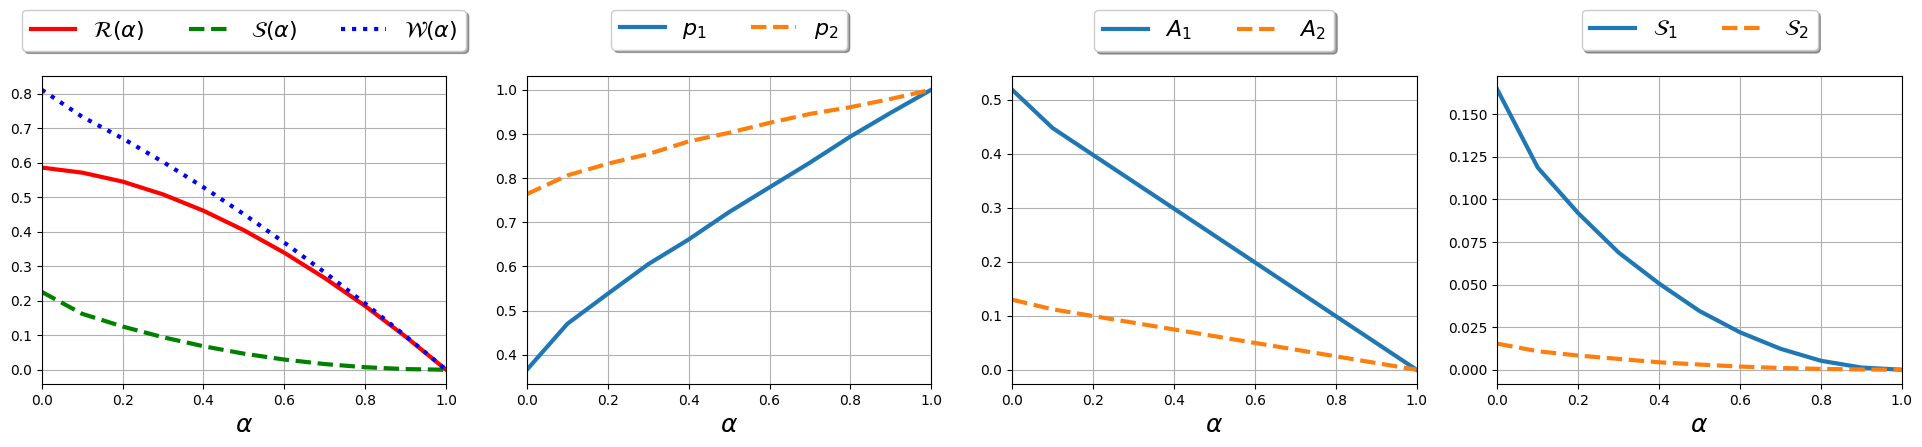

In [14]:
subplot_drawing(rev_list, ts_list, s_list, p_list, a_list, _filename = 'access_fair_mu1_K_5')

{'Price': np.float64(6.0), 'Access': np.float64(0.48178531701891003)}
alpha: 0.0
alpha: 0.1
alpha: 0.2
alpha: 0.3
alpha: 0.4
alpha: 0.5
alpha: 0.6
alpha: 0.7
alpha: 0.8
alpha: 0.9
alpha: 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

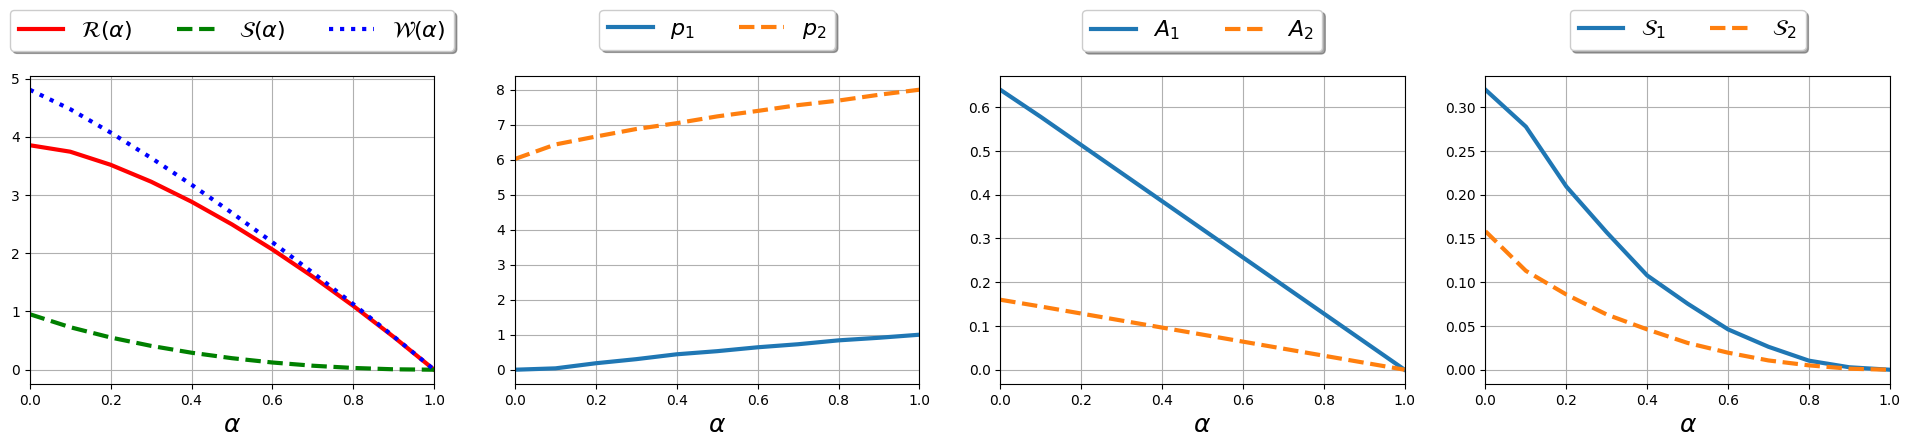

In [17]:
Lambda = [1, 4]
b = [1, 8]
t = [2, 2]
K = 5

rev_list, ts_list, s_list, p_list, a_list = simulator(Lambda, b, t, K, step=0.001, fairness='Access')
subplot_drawing(rev_list, ts_list, s_list, p_list, a_list, _filename = 'access_fair_mu2_K_5')

{'Price': np.float64(3.0), 'Access': np.float64(0.48178531701891003)}
alpha: 0.0
alpha: 0.1
alpha: 0.2
alpha: 0.3
alpha: 0.4
alpha: 0.5
alpha: 0.6
alpha: 0.7
alpha: 0.8
alpha: 0.9
alpha: 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

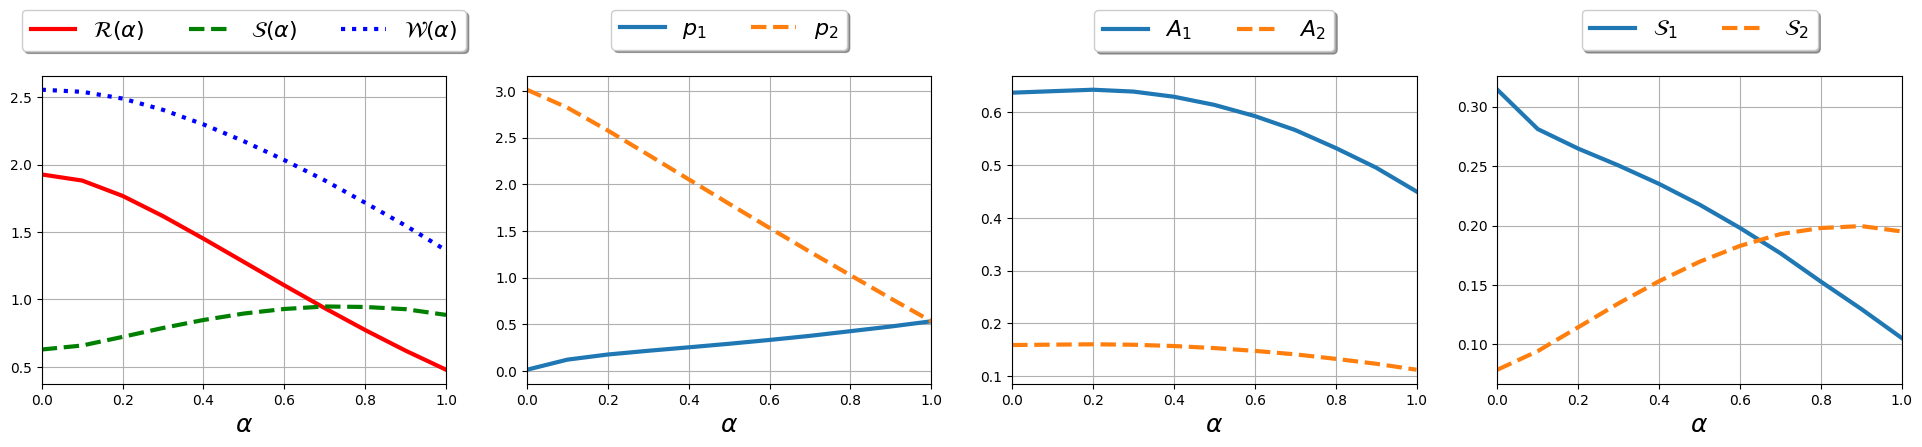

In [18]:
Lambda = [1, 4]
b = [1, 4]
t = [2, 2]
K = 5

rev_list, ts_list, s_list, p_list, a_list = simulator(Lambda, b, t, K, step=0.001, fairness='Price')
subplot_drawing(rev_list, ts_list, s_list, p_list, a_list, _filename = 'price_mu_1_K_5')

{'Price': np.float64(1.6000000000000005), 'Access': np.float64(0.4058402648409414)}
alpha: 0.0
alpha: 0.1
alpha: 0.2
alpha: 0.3
alpha: 0.4
alpha: 0.5
alpha: 0.6
alpha: 0.7
alpha: 0.8
alpha: 0.9
alpha: 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

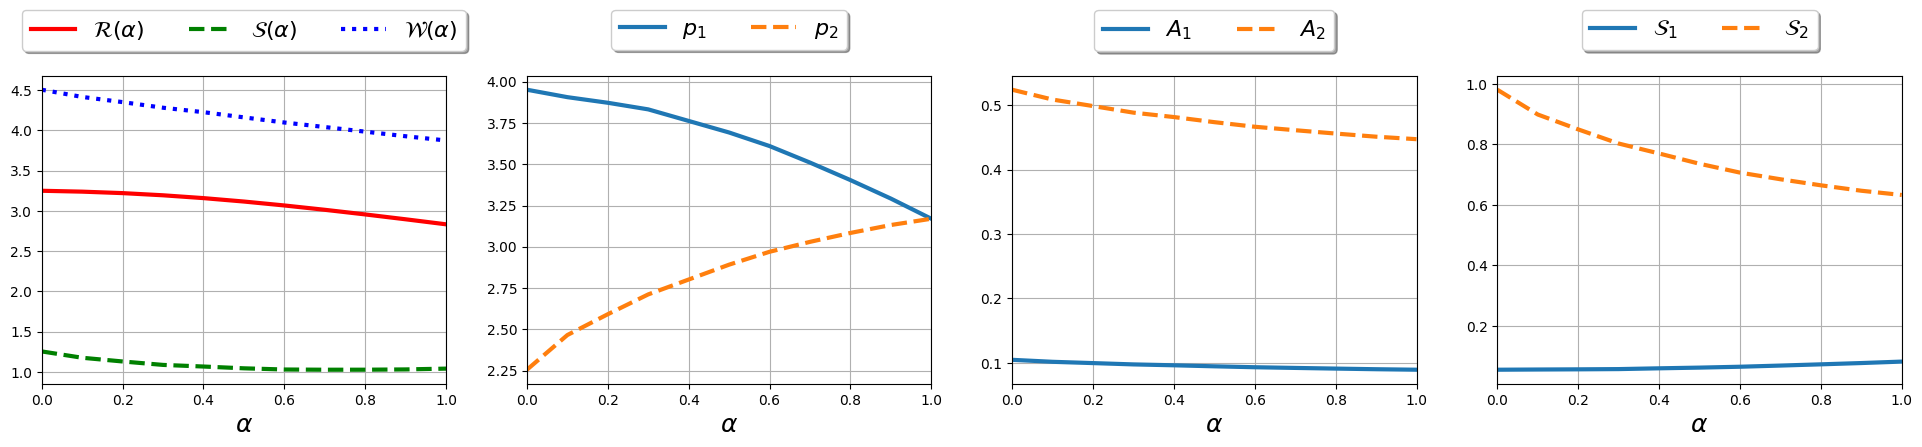

In [19]:
Lambda = [5, 1]
b = [5, 6]
t = [2, 2]
K = 5

rev_list, ts_list, s_list, p_list, a_list = simulator(Lambda, b, t, K, step=0.001, fairness='Price')
subplot_drawing(rev_list, ts_list, s_list, p_list, a_list, _filename = 'price_mu_2_K_5')